# Symmetric vs asymmetric parcellation


In [1]:
import sys
sys.path.append("..")
import ProbabilisticParcellation.evaluate as ev
import ProbabilisticParcellation.util as ut
import ProbabilisticParcellation.export_atlas as ea
import ProbabilisticParcellation.scripts.atlas_paper.parcel_hierarchy as ph
import ProbabilisticParcellation.scripts.atlas_paper.evaluate_atlas as eva
import ProbabilisticParcellation.scripts.atlas_paper.symmetry as sym
import hierarchical_clustering as cl
import Functional_Fusion.dataset as ds
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import torch as pt
import os
import SUITPy as suit
import numpy as np
import Functional_Fusion.atlas_map as am
from matplotlib.colors import ListedColormap
import nitools as nt
import seaborn as sb


In [2]:
figsize = (20, 20)
model_pair = [
        "Models_03/NettekovenSym32_space-MNISymC2",
        "Models_03/NettekovenAsym32_space-MNISymC2",
    ]


atlas = 'MNISymC2'

# Figure settings
figsize = (8, 8)
colorbar = True
bordersize = 4
dtype = 'func'
cmap = 'inferno'
cscale = (0.5, 1)
labels = None

background = 'white'
if background == 'black':
    fontcolor = 'w'
    bordercolor = 'w'
    backgroundcolor = 'k'
elif background == 'white':
    fontcolor = 'k'
    bordercolor = 'k'
    backgroundcolor = 'w'

# Group Symmetry

## Boundary Asymmetry (Group)


In [3]:
# Read in individual and group correlation
asym_sym_corr_group = np.load(f'{ut.model_dir}/Models/{model_pair[0]}_asym_sym_corr_group.npy')
asym_sym_corr_group = asym_sym_corr_group[1, :]
# Set middle to nan
suit_atlas, _ = am.get_atlas(atlas, ut.base_dir + "/Atlases")
indx_middle = np.where(suit_atlas.world[0, :] == 0)[0]
# Set middle to nan
asym_sym_corr_group[indx_middle] = np.nan

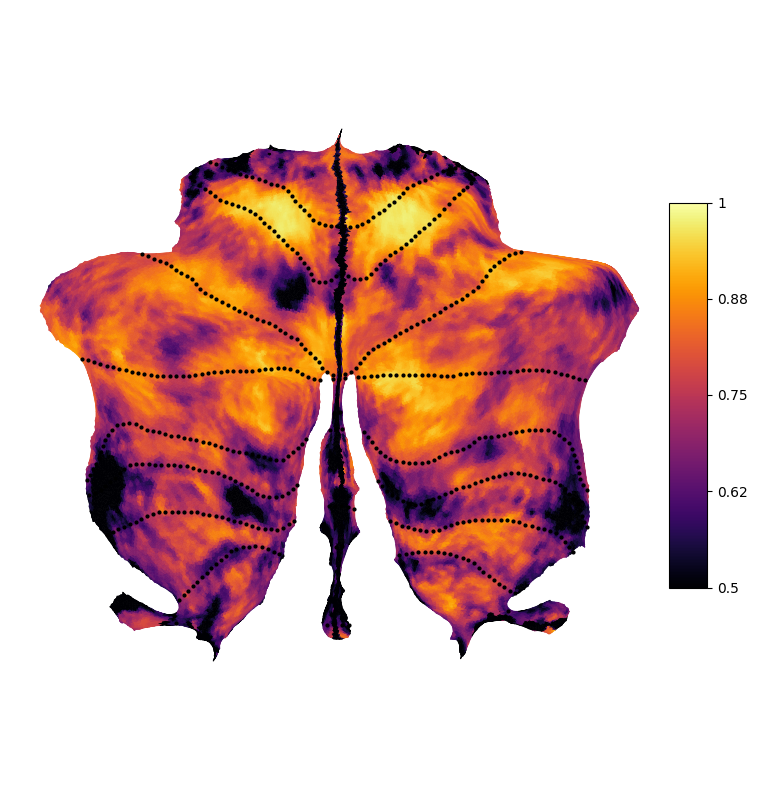

In [4]:
plt.figure(figsize=(10, 10))
ut.plot_data_flat(asym_sym_corr_group, atlas,
                       dtype=dtype,
                       render='matplotlib',
                       cmap='inferno',
                       cscale=cscale,
                       labels=labels,
                        bordercolor=bordercolor,
                        backgroundcolor=backgroundcolor,
                        bordersize=bordersize,
                        colorbar=colorbar,
                        )
plt.savefig(ut.figure_dir + 'Symmetry_boundary_group.png', dpi=300,bbox_inches='tight')


# Projection into parcels (via Probabilistic mean)

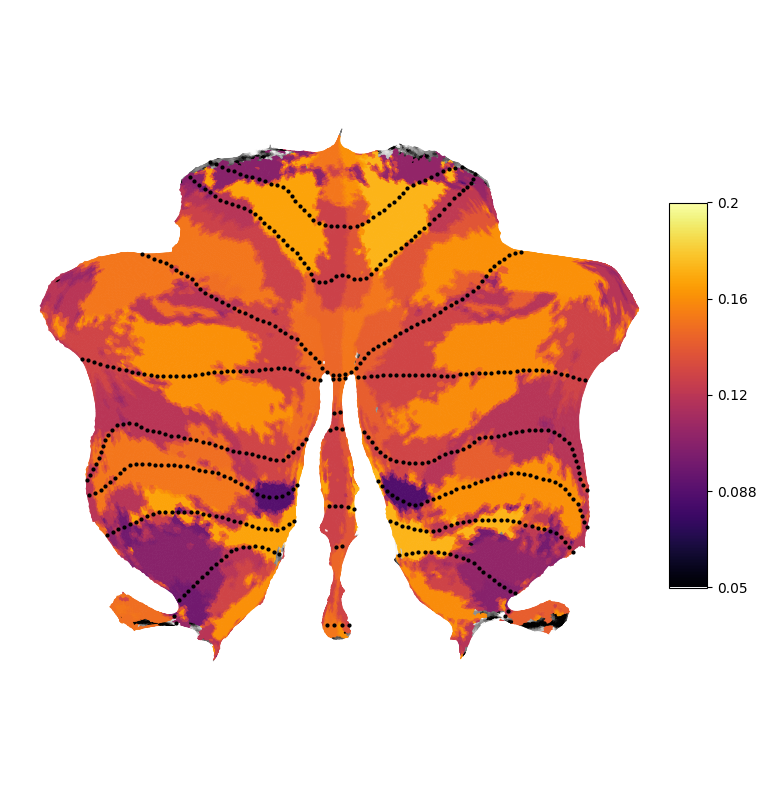

In [5]:
# Boundaty symmetry using probabilistic mean
info, model = ut.load_batch_best(model_pair[0])
# Get winner take-all
Prob_32 = np.array(model.marginal_prob())
parcel_32 = Prob_32.argmax(axis=0) + 1
suit_atlas, _ = am.get_atlas(info.atlas, ut.base_dir + "/Atlases")

# Project into parcellation using probabilistic mean
thresh = 0.1
boundary_sim_prob_avg = np.zeros((32, Prob_32.shape[1])) * np.nan
for p in range(32):
    prob_thres = Prob_32[p, :] > thresh
    boundary_sim_prob_avg[p, :][prob_thres] = np.nanmean(asym_sym_corr_group[prob_thres] *
                                                           Prob_32[p, :][prob_thres])

probabilistic_mean = np.nanmean(boundary_sim_prob_avg, axis=1)


Nifti = suit_atlas.data_to_nifti(parcel_32.astype(float))
surf_parcel = suit.flatmap.vol_to_surf(Nifti, stats='mode',
                                       space='MNISymC', ignore_zeros=True)
surf_parcel = np.nan_to_num(surf_parcel, copy=False).astype(int)
boundary_sim_indiv_parcelwise_prob = np.zeros(surf_parcel.shape) * np.nan
boundary_sim_indiv_parcelwise_prob[surf_parcel >
                                     0] = probabilistic_mean[surf_parcel[surf_parcel > 0] - 1]

# Plot the symmetry map
plt.figure(figsize=(10, 10))
suit.flatmap.plot(boundary_sim_indiv_parcelwise_prob,
                  render='matplotlib',
                  overlay_type='func',
                  new_figure=False,
                  cmap=cmap,
                  bordercolor=bordercolor,
                  backgroundcolor=backgroundcolor,
                  bordersize=bordersize,
                  colorbar=colorbar,
                    cscale=(0.05, 0.2),
                  )
plt.savefig(ut.figure_dir + 'Symmetry_boundary_group_parcel_prob.png',
            dpi=300, bbox_inches='tight')


# Functional Asymmetry (Group)

## Model-based (V vector cosine similarity)

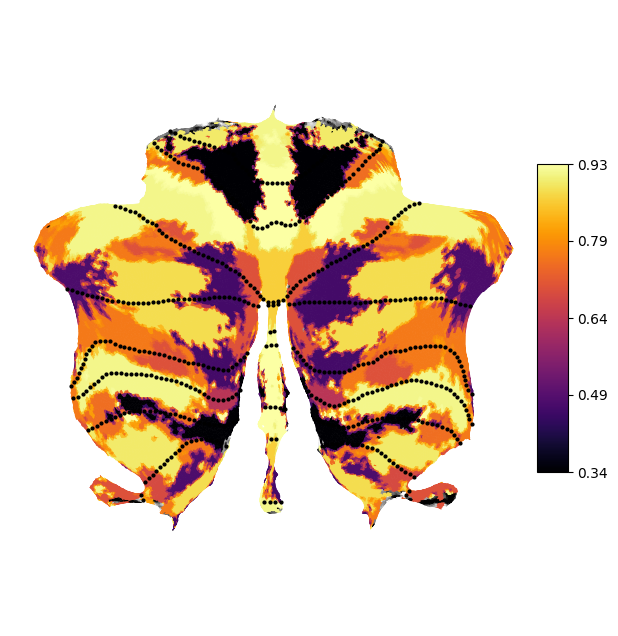

In [6]:
sym_score_model = sym.functional_symmetry(method='model', mname=model_pair[0])

# Map the symmetry to the parcels
functional_symmetry_model_surf = np.zeros(surf_parcel.shape) * np.nan
functional_symmetry_model_surf[surf_parcel >
                               0] = sym_score_model[surf_parcel[surf_parcel > 0] - 1]

# Plot the symmetry map
plt.figure(figsize=figsize)
suit.flatmap.plot(functional_symmetry_model_surf,
                  render='matplotlib',
                  overlay_type='func',
                  new_figure=False,
                  cmap=cmap,
                  bordercolor=bordercolor,
                  backgroundcolor=backgroundcolor,
                  bordersize=bordersize,
                  colorbar=colorbar)
plt.savefig(ut.figure_dir + 'Symmetry_model_group_32.png',
            dpi=300, bbox_inches='tight')


## Data-based (Data vector cosine similarity)

In [7]:
sym_score = np.load(
    f'{ut.model_dir}/Models/Evaluation/nettekoven_68/functional_sim_data.npy')
sym_score_avg = np.nanmean(
    sym_score, axis=0).squeeze().astype(float)
# Set middle to nan
sym_score_avg[indx_middle] = np.nan
sym_score[:, indx_middle] = np.nan

Nifti = suit_atlas.data_to_nifti(sym_score_avg)
sym_score_avg_surf = suit.flatmap.vol_to_surf(Nifti, stats='nanmean',
                                              space='MNISymC', ignore_zeros=False)


In [8]:
# Datasetwise average

# Load number of participants
T = pd.read_csv(ut.base_dir + '/dataset_description.tsv', sep='\t')
n_subjects = T.num_particpants[:7].values
# Make index start at 0
sub_cumulative = np.cumsum(n_subjects) - 1
# print(sub_cumulative)

# Loop through n_subjects and group correlation by dataset
functional_sim_dataset = []
for i in range(len(n_subjects)):
    # print subjects to average to check subject indexing is correct
    if i == 0:
        # print(sub_cumulative[i])
        functional_sim_dataset.append(
            np.nanmean(sym_score[:sub_cumulative[i]], axis=0))
    else:
        # print(sub_cumulative[i-1]+1, sub_cumulative[i])
        functional_sim_dataset.append(
            np.nanmean(sym_score[sub_cumulative[i - 1] + 1:sub_cumulative[i]], axis=0))


/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_35837/808781022.py:17: RuntimeWarning: Mean of empty slice
  np.nanmean(sym_score[:sub_cumulative[i]], axis=0))
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_35837/808781022.py:21: RuntimeWarning: Mean of empty slice
  np.nanmean(sym_score[sub_cumulative[i - 1] + 1:sub_cumulative[i]], axis=0))


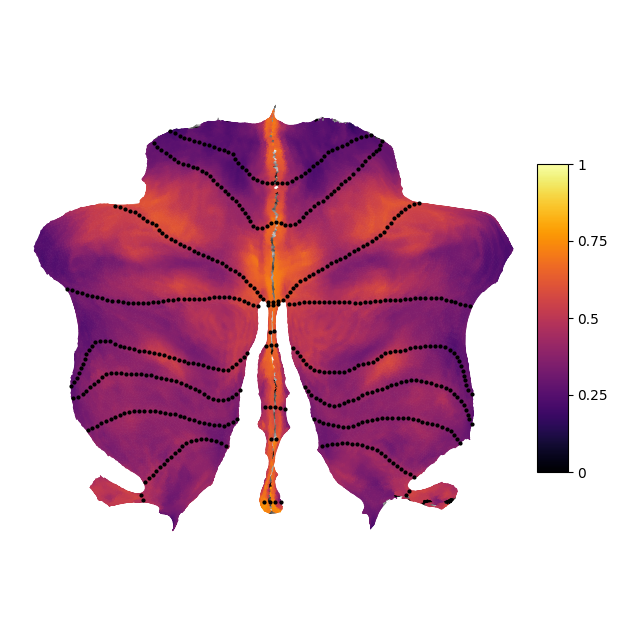

In [9]:
# Plot the symmetry map
plt.figure(figsize=figsize)
suit.flatmap.plot(sym_score_avg_surf,
                  render='matplotlib',
                  overlay_type='func',
                  new_figure=False,
                  cmap=cmap,
                  bordercolor=bordercolor,
                  backgroundcolor=backgroundcolor,
                  bordersize=bordersize,
                  colorbar=colorbar,
                  cscale=(0, 1))
plt.savefig(ut.figure_dir + 'Symmetry_functional_individual.png',
            dpi=300, bbox_inches='tight')

In [10]:
functional_sim_dataset_surf = []
for d, dset in enumerate(T.name[:-1].values):
    Nifti = suit_atlas.data_to_nifti(functional_sim_dataset[d])
    functional_sim_dataset_surf.append(suit.flatmap.vol_to_surf(Nifti, stats='nanmean',
                                                           space='MNISymC', ignore_zeros=False))
    


## Show symmetry within each parcel

In [11]:
# Project into the parcellation
functional_sim_indiv_parcelwise = np.zeros(surf_parcel.shape) * np.nan
for i in surf_parcel[surf_parcel > 0]:
    functional_sim_indiv_parcelwise[np.where(surf_parcel == i)] = np.nanmean(
        sym_score_avg_surf[np.where(surf_parcel == i)].squeeze())



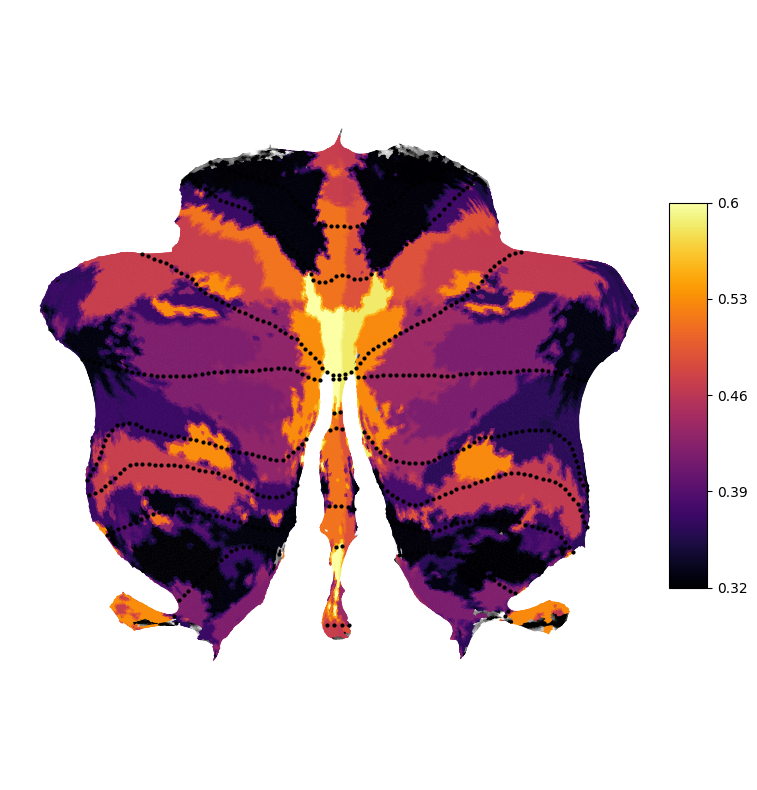

In [12]:
# Plot the symmetry map
plt.figure(figsize=(10, 10))
suit.flatmap.plot(functional_sim_indiv_parcelwise,
                  render='matplotlib',
                  overlay_type='func',
                  new_figure=False,
                  cmap=cmap,
                  bordercolor=bordercolor,
                  backgroundcolor=backgroundcolor,
                  bordersize=bordersize,
                  colorbar=colorbar,
                  # cscale=cscale,
                  )
plt.savefig(ut.figure_dir + 'Symmetry_data_indiv_parcel.png',
            dpi=300, bbox_inches='tight')


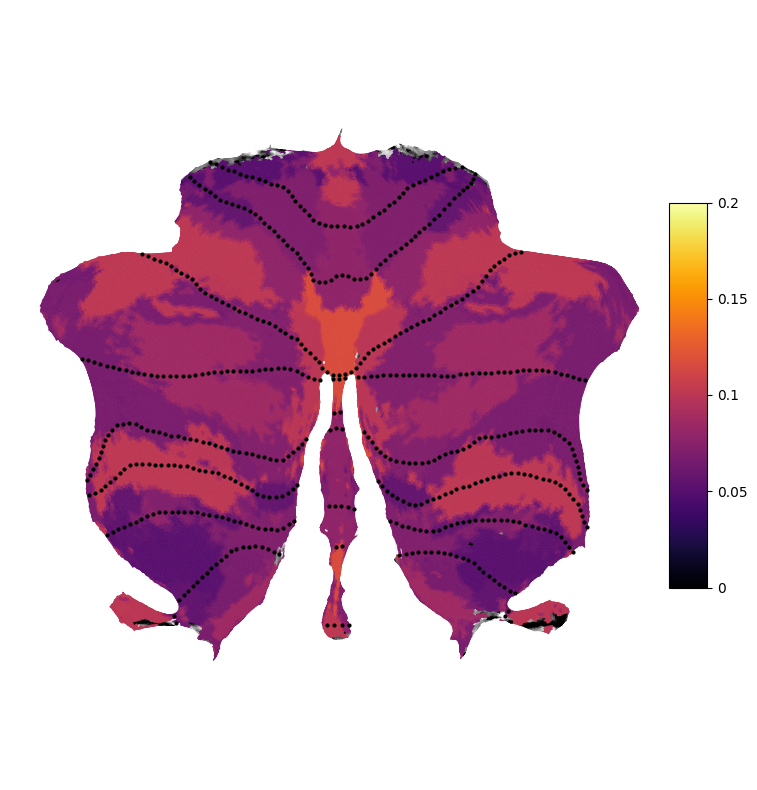

In [13]:

# Project into parcellation using probabilistic mean
thresh=0.1
functional_sim_prob_avg = np.zeros((32, Prob_32.shape[1])) * np.nan
for p in range(32):
    prob_thres = Prob_32[p, :] > thresh
    functional_sim_prob_avg[p, :][prob_thres] = np.nanmean(sym_score_avg[prob_thres] * \
        Prob_32[p, :][prob_thres])


# np.nanmean(sym_score_avg[np.argmax(Prob_32, axis=0) == 0])
# np.nanmean(sym_score_avg*Prob_32[0,:])
probabilistic_mean = np.nanmean(functional_sim_prob_avg, axis=1)
functional_sim_indiv_parcelwise_prob = np.zeros(surf_parcel.shape) * np.nan
functional_sim_indiv_parcelwise_prob[surf_parcel >
                                     0] = probabilistic_mean[surf_parcel[surf_parcel > 0] - 1]

# Plot the symmetry map
plt.figure(figsize=(10, 10))
suit.flatmap.plot(functional_sim_indiv_parcelwise_prob,
                  render='matplotlib',
                  overlay_type='func',
                  new_figure=False,
                  cmap=cmap,
                  cscale=(0, 0.2),
                  bordercolor=bordercolor,
                  backgroundcolor=backgroundcolor,
                  bordersize=bordersize,
                  colorbar=colorbar,
                  #   cscale=cscale,
                  )
plt.savefig(ut.figure_dir + 'Symmetry_data_indiv_parcel_prob.png',
            dpi=300, bbox_inches='tight')


# Individual Asymmetry

## Boundary Asymmetry (Individual)


In [14]:
asym_sym_corr_indiv = np.load(
    f'{ut.model_dir}/Models/{model_pair[0]}_asym_sym_corr_indiv.npy')
# Set middle to nan
asym_sym_corr_indiv[:, indx_middle] = np.nan


In [15]:
# Loop through n_subjects and group correlation by dataset
corr_dataset = []
for i in range(len(n_subjects)):
    # print subjects to average to check subject indexing is correct
    if i == 0:
        # print(sub_cumulative[i])
        corr_dataset.append(asym_sym_corr_indiv[:sub_cumulative[i]].mean(axis=0))
    else:
        # print(sub_cumulative[i-1]+1, sub_cumulative[i])
        corr_dataset.append(
            asym_sym_corr_indiv[sub_cumulative[i-1]+1:sub_cumulative[i]].mean(axis=0))


## Average only symmetric datasets (Md, Po, Wm, De, So)

In [16]:
# Average symmetric datasets
symmetric_datasets = ['Md', 'Po', 'Wm', 'De', 'So']
# Get indices of symmetric datasets
symmetric_indices = [i for i, x in enumerate(T.two_letter_code) if x in symmetric_datasets]

# Collect only numpy arrays from symmetric indices
corr_dataset_sym = [corr_dataset[i] for i in symmetric_indices]

# Stack
corr_dataset_sym = np.stack(corr_dataset_sym, axis=0)
# Average
corr_dataset_sym = corr_dataset_sym.mean(axis=0).squeeze()


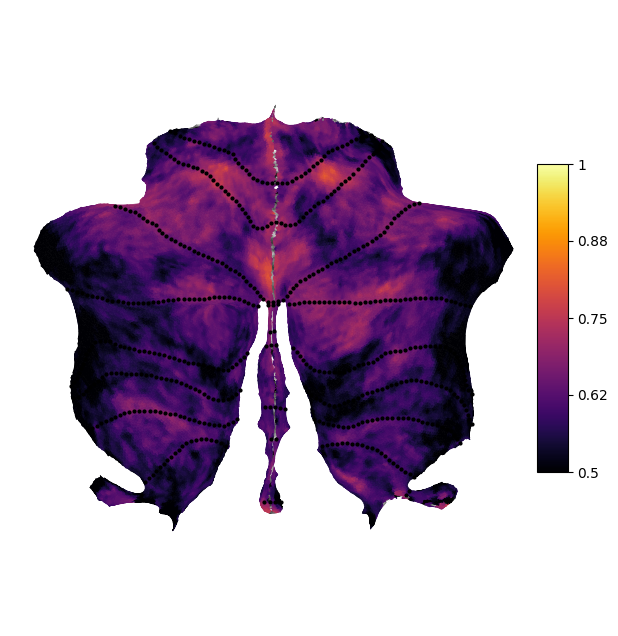

In [17]:
Nifti = suit_atlas.data_to_nifti(corr_dataset_sym)
corr_dataset_sym_surf = suit.flatmap.vol_to_surf(Nifti, stats='nanmean',
                                              space='MNISymC', ignore_zeros=False)
plt.figure(figsize=figsize)
suit.flatmap.plot(corr_dataset_sym_surf,
                  render='matplotlib',
                  overlay_type='func',
                  new_figure=False,
                  cmap=cmap,
                  bordercolor=bordercolor,
                  backgroundcolor=backgroundcolor,
                  bordersize=bordersize,
                  colorbar=colorbar,
                  cscale=cscale)
plt.savefig(ut.figure_dir + 'Symmetry_boundary_symmetric-individual_symdatasets.png',
            dpi=300, bbox_inches='tight')

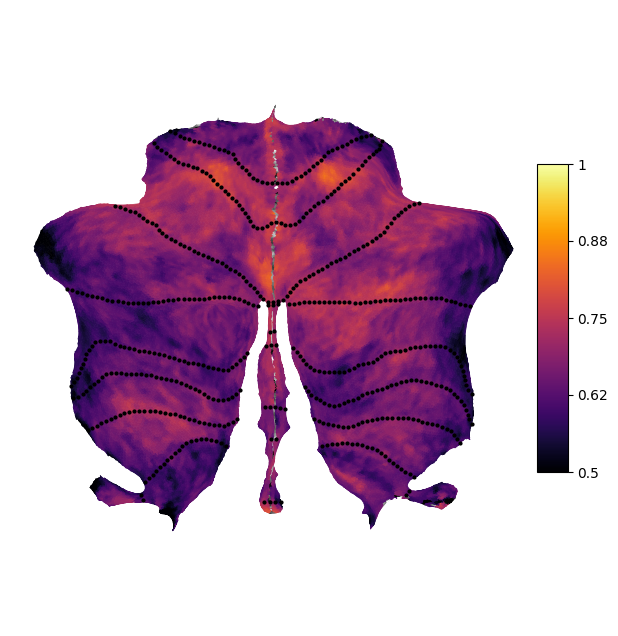

In [18]:
# All datasets
corr_dataset_all = [corr_dataset[i] for i in np.arange(0, len(corr_dataset))]
corr_dataset_all = np.stack(corr_dataset_all, axis=0)
corr_dataset_all = corr_dataset_all.mean(axis=0).squeeze()

corr_dataset_all 
Nifti = suit_atlas.data_to_nifti(corr_dataset_all)
corr_dataset_sym_surf = suit.flatmap.vol_to_surf(Nifti, stats='nanmean',
                                              space='MNISymC', ignore_zeros=False)
plt.figure(figsize=figsize)
suit.flatmap.plot(corr_dataset_sym_surf,
                  render='matplotlib',
                  overlay_type='func',
                  new_figure=False,
                  cmap=cmap,
                  bordercolor=bordercolor,
                  backgroundcolor=backgroundcolor,
                  bordersize=bordersize,
                  colorbar=colorbar,
                  cscale=(0.5,1))
plt.savefig(ut.figure_dir + 'Symmetry_boundary_symmetric-individual_alldatasets.png',
            dpi=300, bbox_inches='tight')

# Size comparison between asymmetric and symmetric atlas

In [3]:
# Get probability mass for each of the left and right parcels of the asymmetric atlas
# Load asymmetric atlas
infos, models = [], []
for mname in model_pair:
    info, model = ut.load_batch_best(mname)
    infos.append(info)
    models.append(model)


In [4]:

fileparts = mname.split('/')
index, cmap, labels = nt.read_lut(ut.export_dir + '/' +
                                      fileparts[-1].split('_space')[0] + '.lut')

prob_sym_group = models[0].arrange.marginal_prob()
prob_asym_group = models[1].arrange.marginal_prob()

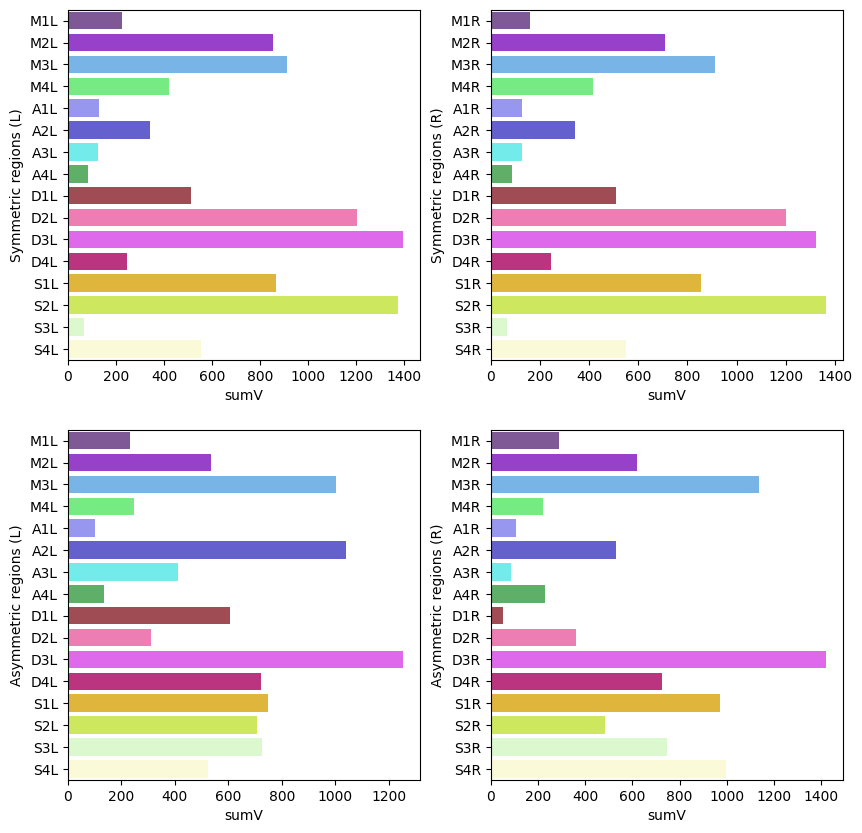

In [5]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
D = cl.plot_parcel_size(prob_sym_group, ListedColormap(cmap), labels, wta=True, sort=False, side='L')
plt.ylabel('Symmetric regions (L)')

plt.subplot(2, 2, 2)
D = cl.plot_parcel_size(prob_sym_group, ListedColormap(cmap), labels, wta=True, sort=False, side='R')
plt.ylabel('Symmetric regions (R)')

plt.subplot(2, 2, 3)
D = cl.plot_parcel_size(prob_asym_group, ListedColormap(cmap), labels, wta=True, sort=False, side='L')
plt.ylabel('Asymmetric regions (L)')

plt.subplot(2, 2, 4)
D = cl.plot_parcel_size(prob_asym_group, ListedColormap(cmap), labels, wta=True, sort=False, side='R')
plt.ylabel('Asymmetric regions (R)')

plt.savefig(ut.figure_dir + f"parcel_sizes_sym_vs_asym_wta.pdf")




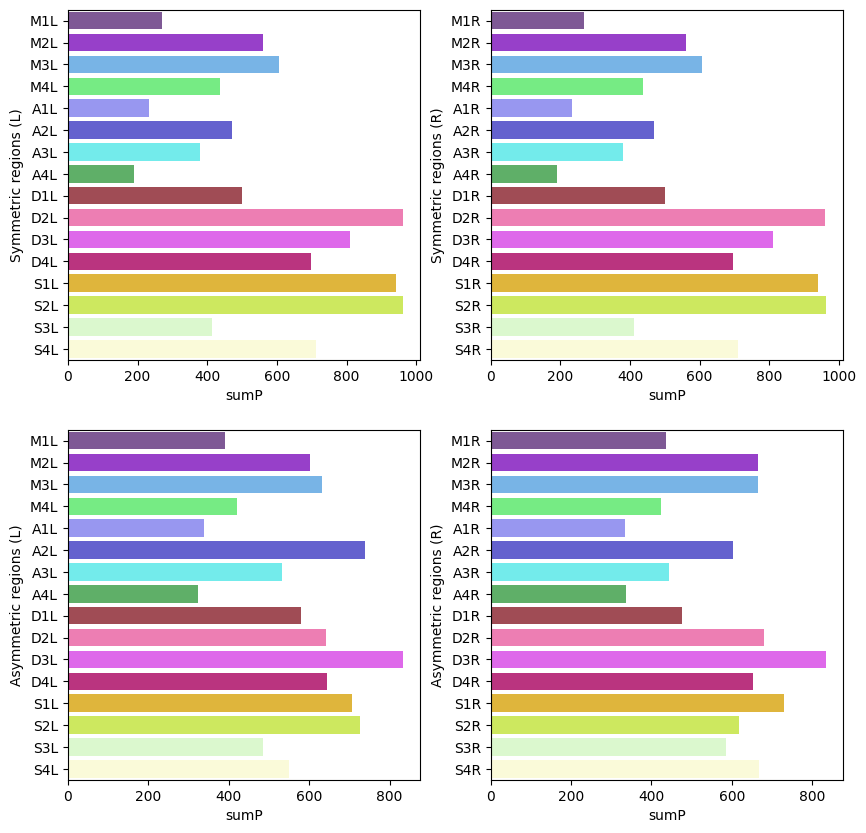

In [6]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
D = cl.plot_parcel_size(prob_sym, ListedColormap(cmap), labels, wta=False, sort=False, side='L')
plt.ylabel('Symmetric regions (L)')

plt.subplot(2, 2, 2)
D = cl.plot_parcel_size(prob_sym, ListedColormap(cmap), labels, wta=False, sort=False, side='R')
plt.ylabel('Symmetric regions (R)')

plt.subplot(2, 2, 3)
D = cl.plot_parcel_size(prob_asym, ListedColormap(cmap), labels, wta=False, sort=False, side='L')
plt.ylabel('Asymmetric regions (L)')

plt.subplot(2, 2, 4)
D = cl.plot_parcel_size(prob_asym, ListedColormap(cmap), labels, wta=False, sort=False, side='R')
plt.ylabel('Asymmetric regions (R)')

plt.savefig(ut.figure_dir + f"parcel_sizes_sym_vs_asym_prob.pdf")




In [191]:
sym_sumP_group, sym_sumV_group = cl.calc_parcel_size(prob_sym)
asym_sumP_group, asym_sumV_group = cl.calc_parcel_size(prob_asym)
# Compare probability masses
mass_change = (asym_sumP_group - sym_sumP_group) / sym_sumP_group
voxel_change = (asym_sumV_group - sym_sumV_group) / sym_sumV_group


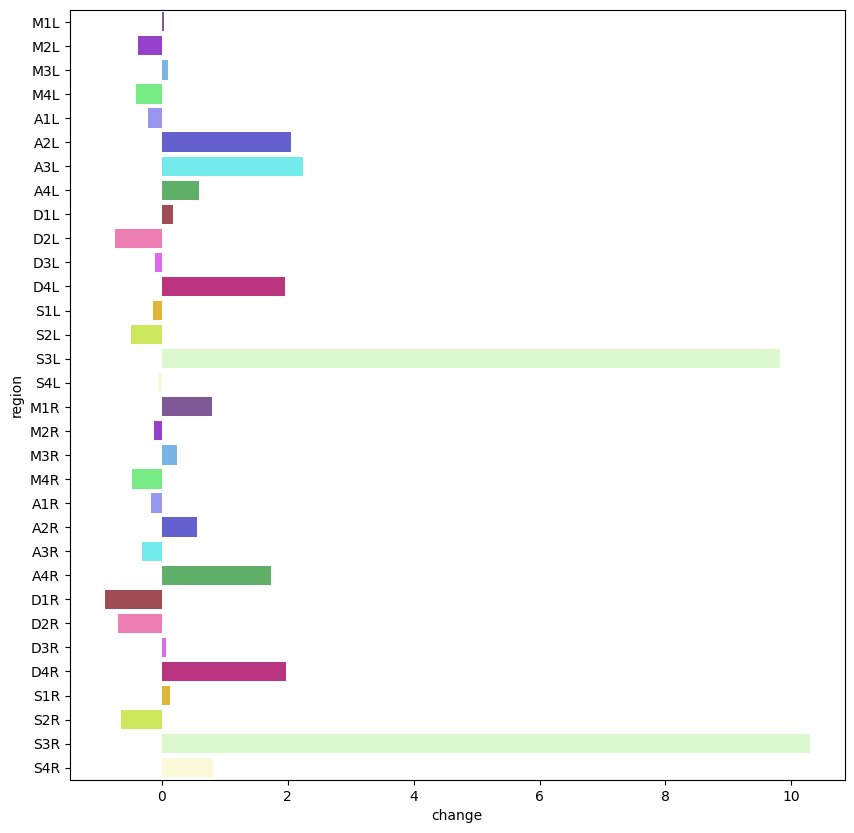

In [194]:
Dvox = pd.DataFrame({'region': labels[1:],
                      'change': voxel_change,
                      'cnum': np.arange(voxel_change.shape[0]) + 1})

pal = {d.region: ListedColormap(cmap)(d.cnum) for i, d in Dvox.iterrows()}

plt.figure(figsize=(10, 10))
sb.barplot(data=Dvox, y='region', x='change', palette=pal)
plt.savefig(ut.figure_dir + f"parcel_sizes_sym_vs_asym_wta.pdf")


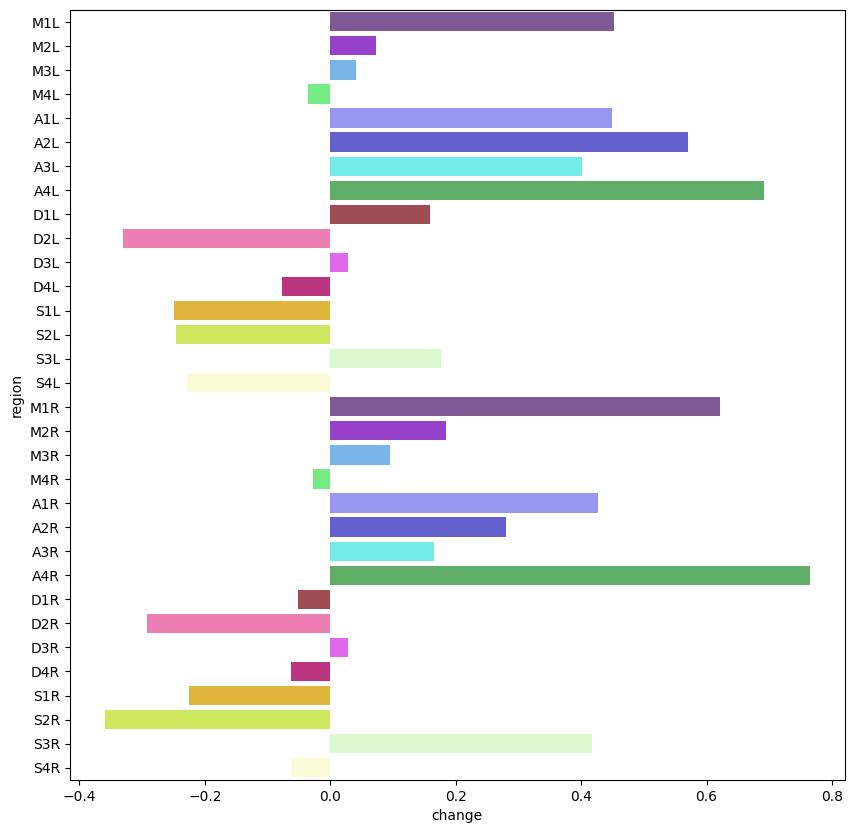

In [193]:
Dmass = pd.DataFrame({'region': labels[1:],
                      'change': mass_change,
                      'cnum': np.arange(mass_change.shape[0]) + 1})

pal = {d.region: ListedColormap(cmap)(d.cnum) for i, d in Dmass.iterrows()}

plt.figure(figsize=(10, 10))
sb.barplot(data=Dmass, y='region', x='change', palette=pal)
plt.savefig(ut.figure_dir + f"parcel_sizes_sym_vs_asym_prob.pdf")


# Size difference between the left and right regions in the individual

In [10]:
sym_uhats = pt.load(f"{ut.model_dir}/Models/{model_pair[0]}_Uhat.pt")
asym_uhats = pt.load(f"{ut.model_dir}/Models/{model_pair[1]}_Uhat.pt")

In [11]:
# Get winner-take all assignment
sym_parcels = pt.argmax(sym_uhats, dim=1) + 1
asym_parcels = pt.argmax(asym_uhats, dim=1) + 1

# Get parcel sizes
sym_sumP, sym_sumV = cl.calc_parcel_size(sym_uhats)
asym_sumP, asym_sumV = cl.calc_parcel_size(asym_uhats)

In [12]:
def plot_counts_hist(sym_counts, asym_counts, labels, subplot=False):
    if sym_counts[0][0].is_integer():
        title = 'Voxel'
    else:
        title = 'Probability Mass'

    if subplot:
        plt.figure(figsize=(10,10))
        # cols = int(np.ceil(np.sqrt(sym_counts.shape[1])))
        cols = 4
        rows = int(np.ceil(sym_counts.shape[1]/cols))
        for region_index in np.arange(0, sym_sumV.shape[1]):
            plt.subplot(rows, cols, region_index+1)
            # for region_index in np.arange(0, 2):
            sb.histplot(sym_counts[:, region_index], color='blue', alpha=0.5, label='Symmetric')
            sb.histplot(asym_counts[:, region_index], color='green', alpha=0.5, label='Asymmetric')
            if (region_index/rows).is_integer():
                plt.xlabel(f'{title} Count')
            if (region_index/cols).is_integer() or region_index==0:
                plt.ylabel('N subjects')
            
            
            # plt.legend()
            plt.tight_layout()
            plt.title(f'{labels[region_index +1]}')
        plt.legend()
    else:
        for region_index in np.arange(0, sym_sumV.shape[1]):
        # for region_index in np.arange(0, 2):
            sb.histplot(sym_counts[:, region_index], color='blue', alpha=0.5, label='Symmetric')
            sb.histplot(asym_counts[:, region_index], color='green', alpha=0.5, label='Asymmetric')
            plt.xlabel(f'{title} Count')
            plt.ylabel('N subjects')
            plt.legend()
            plt.tight_layout()
            plt.title(f'{labels[region_index +1]}')
            plt.show()





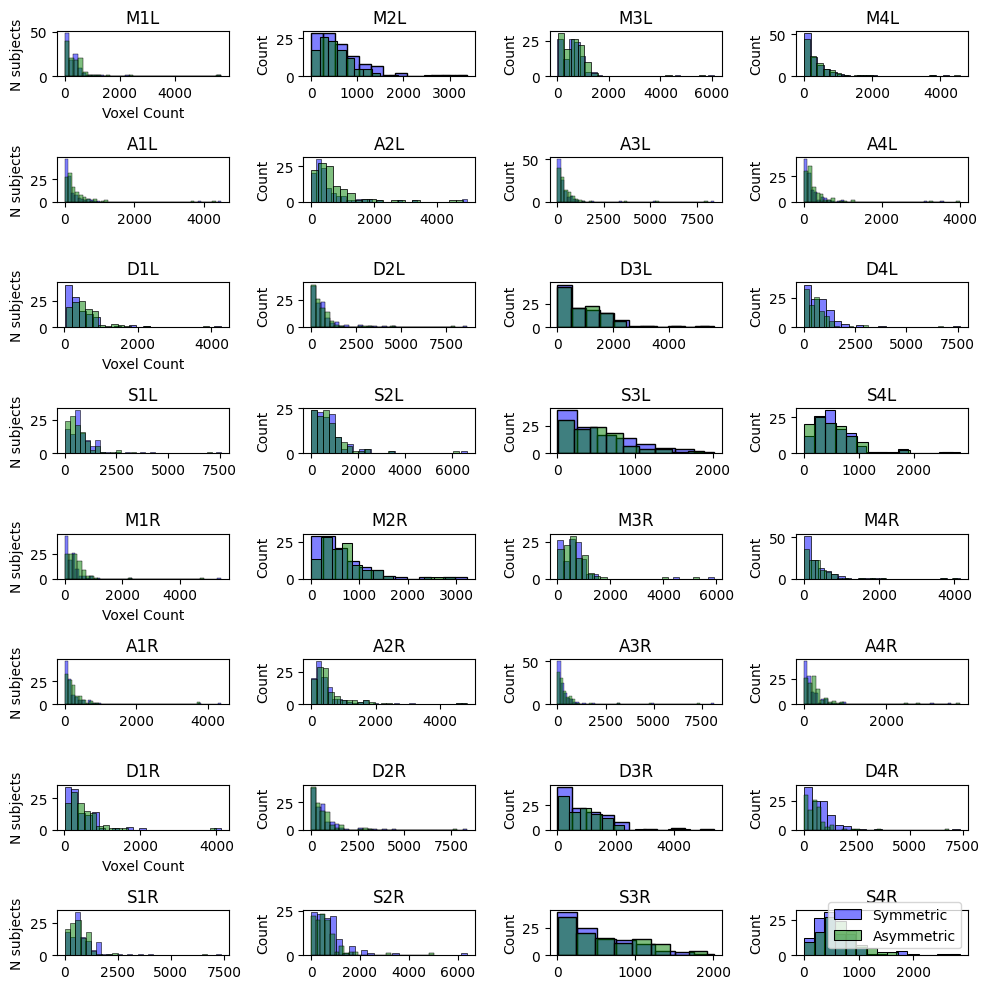

In [13]:
plot_counts_hist(sym_sumV, asym_sumV, labels, subplot=True)

In [154]:
len(regions)


(7104,)

In [156]:
# subjects = np.stack((np.arange(0, sym_sumV.shape[0]), np.arange(0, sym_sumV.shape[0])))
# subjects = np.repeat(subjects, 32, axis=0).flatten()
region_labels = labels[1:]
regions = np.stack((region_labels, region_labels))
regions = np.repeat(regions, sym_sumV.shape[0], axis=0).flatten()

symmetry = np.repeat(np.stack(['sym', 'asym']), sym_sumV.flatten().shape[0], axis=0).flatten()
subjects = [f'sub-{n+1}' for n in np.repeat(np.arange(0, sym_sumV.shape[0]),len(region_labels))] + [f'sub-{n+1}' for n in np.repeat(np.arange(0, sym_sumV.shape[0]),len(region_labels))]


df = pd.DataFrame({
# 'subject': subjects,
# 'region': list(np.repeat(labels[1:], 222)),
'subject': subjects,
'region': regions,
'cnum': np.repeat(np.stack((np.arange(len(region_labels)) + 1, np.arange(len(region_labels)) + 1)), 111, axis=0).flatten(),
'voxels': np.concatenate((sym_sumV.flatten(), asym_sumV.flatten())),
'prob': np.concatenate((sym_sumP.flatten(), asym_sumP.flatten())),
'symmetry': symmetry
}
)
df['side'] = df['region'].str[-1]
df['region'] = df['region'].str[:-1]
df['domain'] = df['region'].str[0]

## Calculate change in individuals

In [164]:
df[df.symmetry=='asym'].voxels.values

array([1582.,  109.,  952., ...,  248., 1142.,  762.])

In [171]:
df[df.symmetry=='sym']

,subject,region,cnum,voxels,prob,symmetry,side,domain
0,sub-1,M1,1,1307.0,1309.300293,sym,L,M
1,sub-1,M2,2,149.0,152.672440,sym,L,M
2,sub-1,M3,3,988.0,985.095764,sym,L,M
3,sub-1,M4,4,295.0,297.800842,sym,L,M
4,sub-1,A1,5,976.0,964.589844,sym,L,A
...,...,...,...,...,...,...,...,...
3547,sub-111,D4,28,147.0,156.544815,sym,R,D
3548,sub-111,S1,29,3629.0,3593.000732,sym,R,S
3549,sub-111,S2,30,287.0,395.467590,sym,R,S
3550,sub-111,S3,31,94.0,95.795662,sym,R,S


In [170]:
df[df.symmetry=='asym']

,subject,region,cnum,voxels,prob,symmetry,side,domain
3552,sub-1,M1,1,1582.0,1486.282227,asym,L,M
3553,sub-1,M2,2,109.0,103.420044,asym,L,M
3554,sub-1,M3,3,952.0,930.415771,asym,L,M
3555,sub-1,M4,4,210.0,201.654724,asym,L,M
3556,sub-1,A1,5,1202.0,1184.263428,asym,L,A
...,...,...,...,...,...,...,...,...
7099,sub-111,D4,28,147.0,161.256378,asym,R,D
7100,sub-111,S1,29,2358.0,2331.031006,asym,R,S
7101,sub-111,S2,30,248.0,350.328644,asym,R,S
7102,sub-111,S3,31,1142.0,1113.663330,asym,R,S


In [168]:
voxel_change_indiv = (df[df.symmetry=='asym'].voxels.values - df[df.symmetry=='sym'].voxels.values) / df[df.symmetry=='sym'].voxels.values
df_change = df[['subject', 'region', 'cnum', 'side', 'domain']][df.symmetry == 'sym']
df_change['change'] = voxel_change_indiv
df_change



/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_48414/117604779.py:1: RuntimeWarning: divide by zero encountered in divide
  voxel_change_indiv = (df[df.symmetry=='asym'].voxels.values - df[df.symmetry=='sym'].voxels.values) / df[df.symmetry=='sym'].voxels.values
/var/folders/y1/13zjm1t50ms6ds24c69y7vx40000gn/T/ipykernel_48414/117604779.py:1: RuntimeWarning: invalid value encountered in divide
  voxel_change_indiv = (df[df.symmetry=='asym'].voxels.values - df[df.symmetry=='sym'].voxels.values) / df[df.symmetry=='sym'].voxels.values


,subject,region,cnum,side,domain,change
0,sub-1,M1,1,L,M,0.210406
1,sub-1,M2,2,L,M,-0.268456
2,sub-1,M3,3,L,M,-0.036437
3,sub-1,M4,4,L,M,-0.288136
4,sub-1,A1,5,L,A,0.231557
...,...,...,...,...,...,...
3547,sub-111,D4,28,R,D,0.000000
3548,sub-111,S1,29,R,S,-0.350234
3549,sub-111,S2,30,R,S,-0.135889
3550,sub-111,S3,31,R,S,11.148936


<AxesSubplot: xlabel='region', ylabel='change'>

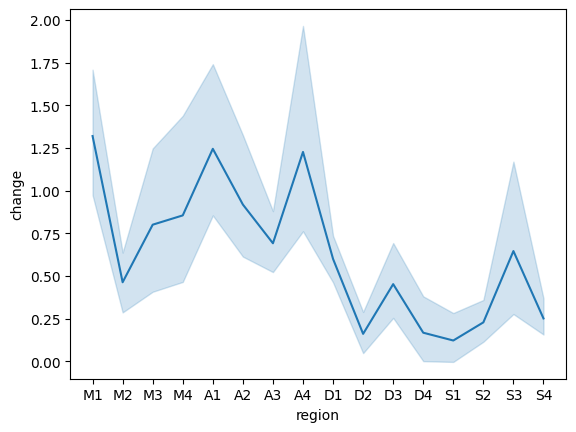

In [162]:
sb.lineplot(data=df_change, y='change', x='region')

/Users/callithrix/code/Python/ProbabilisticParcellation/env/lib/python3.9/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/callithrix/code/Python/ProbabilisticParcellation/env/lib/python3.9/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/callithrix/code/Python/ProbabilisticParcellation/env/lib/python3.9/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/callithrix/code/Python/ProbabilisticParcellation/env/lib/python3.9/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/callithrix/code/Python/ProbabilisticParcellation/env/lib/python3.9/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = 

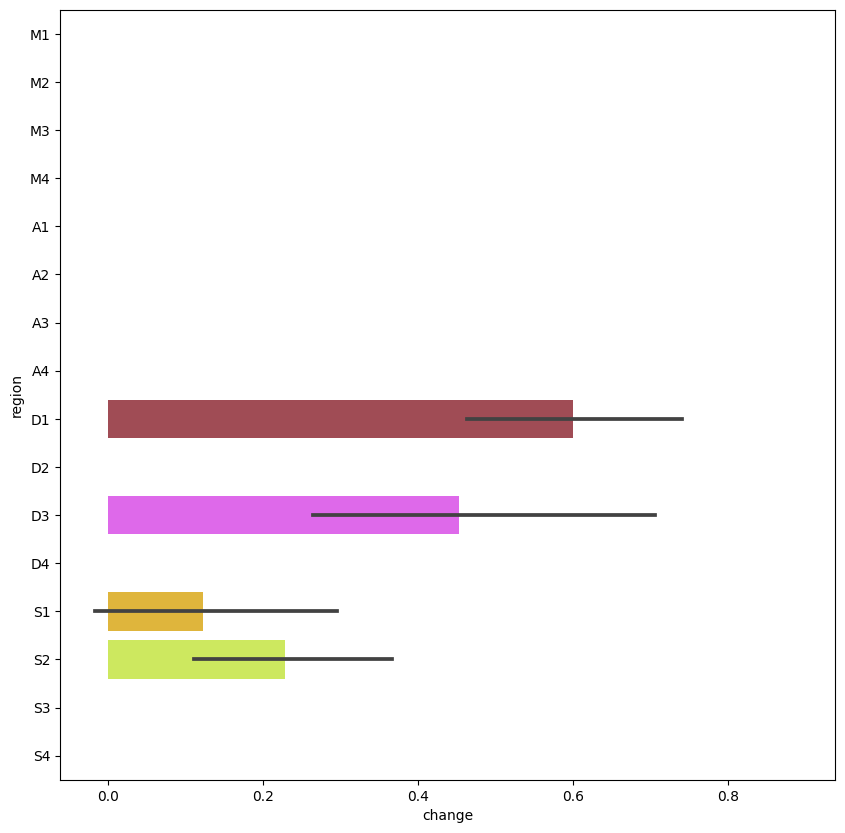

In [160]:
pal = {d.region: ListedColormap(cmap)(d.cnum) for i, d in df_change.iterrows()}

plt.figure(figsize=(10, 10))
sb.barplot(data=df_change, y='region', x='change', palette=pal)
plt.savefig(ut.figure_dir + f"parcel_sizes_sym_vs_asym_indiv.pdf")


In [120]:
voxel_change_indiv.shape

(3552,)

In [ ]:
sb.catplot(df, row='region', col='side', kind='count', hue='symmetry', x='voxels', n_boot=20)

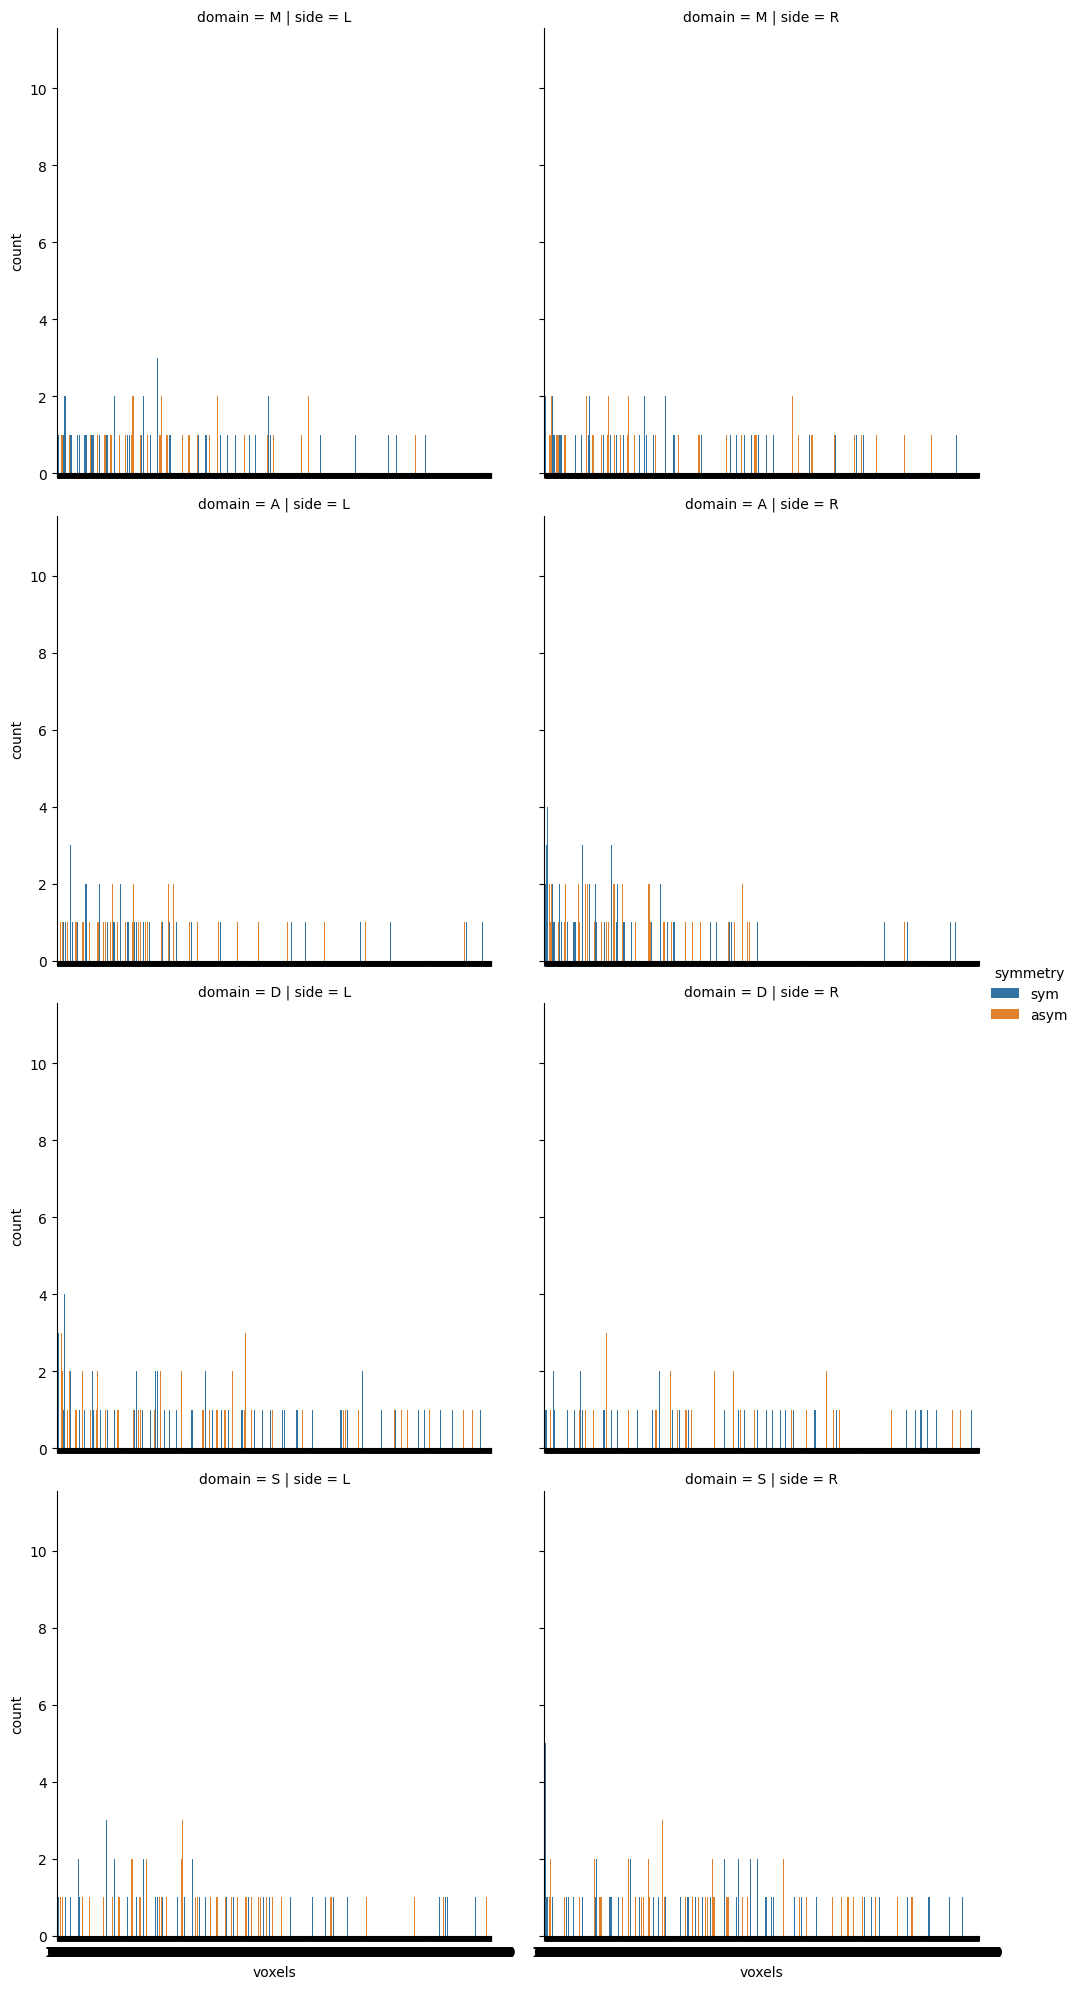

In [106]:
sb.catplot(df, row='domain', col='side', kind='count', hue='symmetry', x='voxels', n_boot=2000)

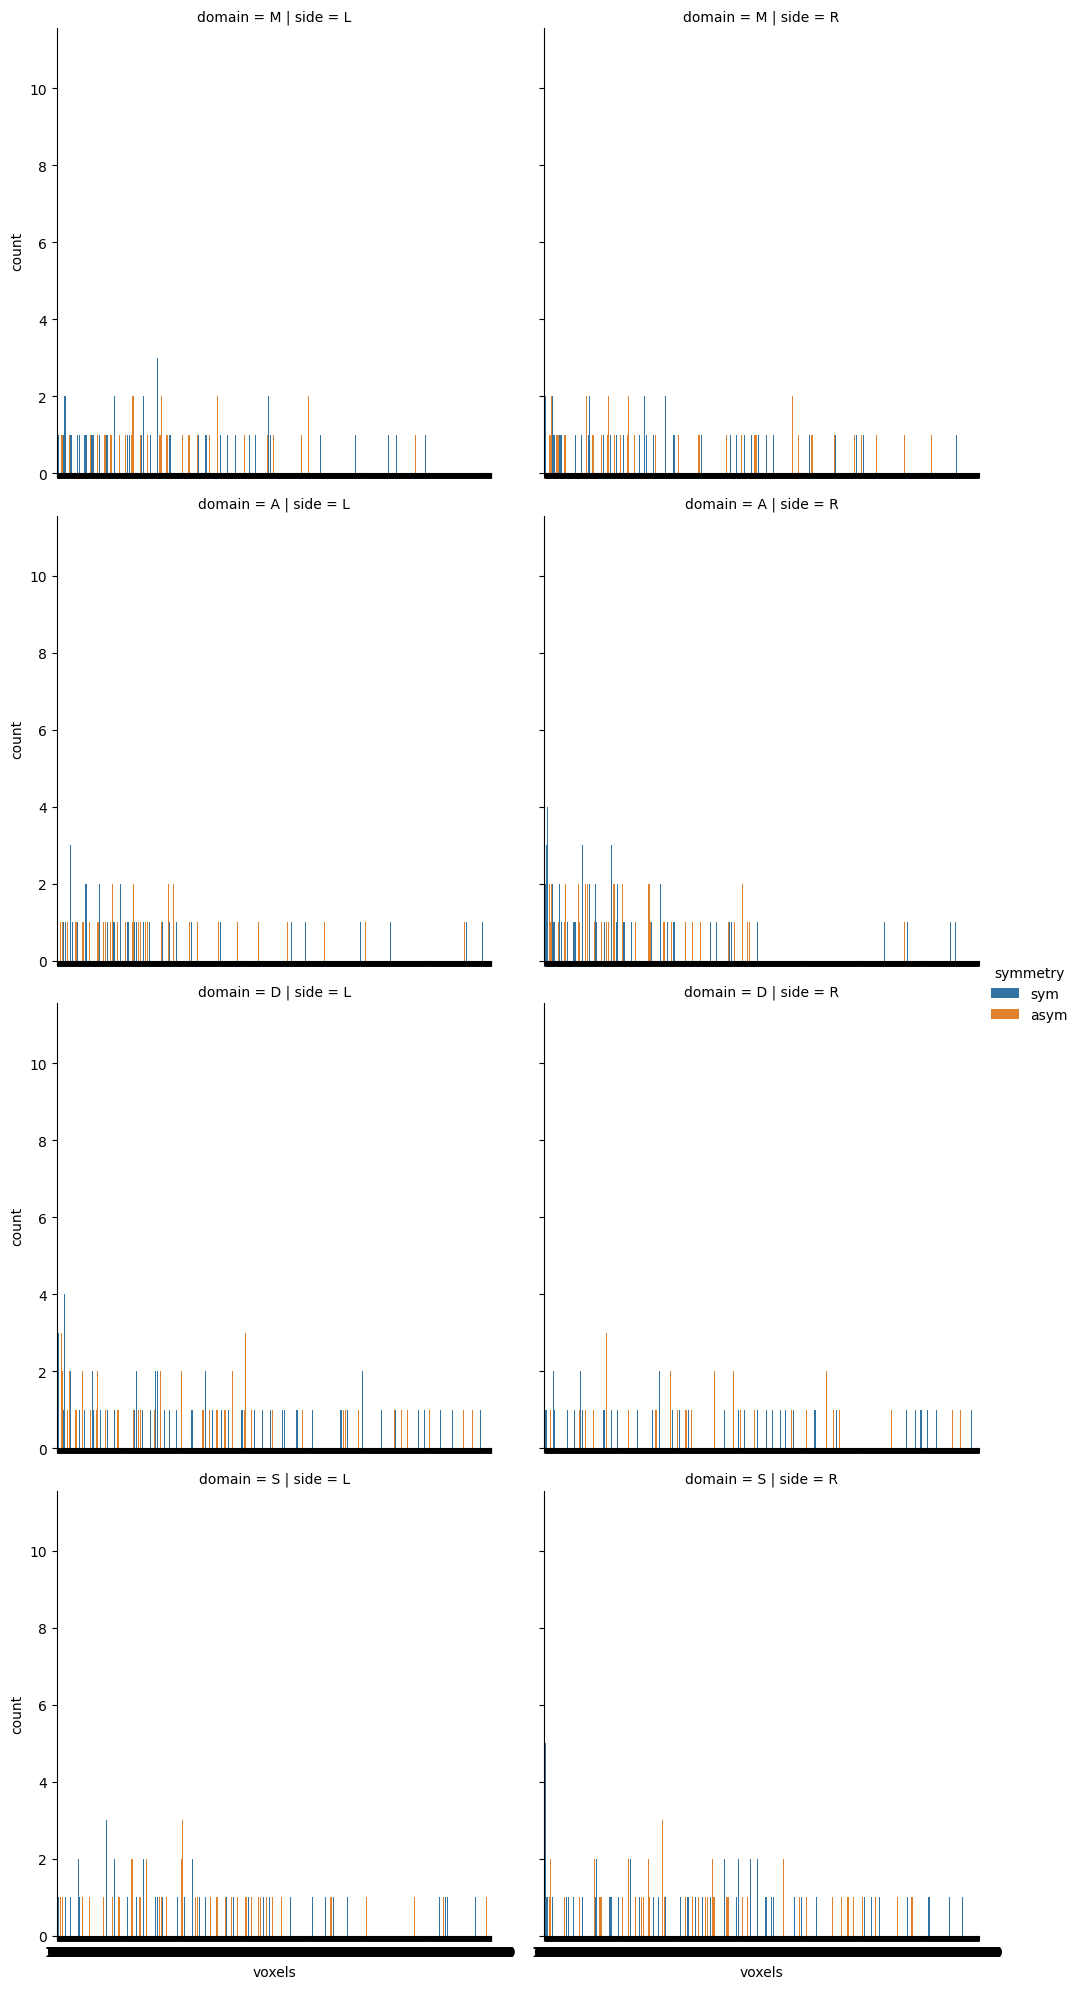

In [23]:
sb.catplot(df, row='domain', col='side', kind='count', hue='symmetry', x='voxels')

In [21]:
help(sb.catplot)

Help on function catplot in module seaborn.categorical:

catplot(data=None, *, x=None, y=None, hue=None, row=None, col=None, col_wrap=None, estimator='mean', errorbar=('ci', 95), n_boot=1000, units=None, seed=None, order=None, hue_order=None, row_order=None, col_order=None, height=5, aspect=1, kind='strip', native_scale=False, formatter=None, orient=None, color=None, palette=None, hue_norm=None, legend='auto', legend_out=True, sharex=True, sharey=True, margin_titles=False, facet_kws=None, ci='deprecated', **kwargs)
    Figure-level interface for drawing categorical plots onto a FacetGrid.
    
    This function provides access to several axes-level functions that
    show the relationship between a numerical and one or more categorical
    variables using one of several visual representations. The `kind`
    parameter selects the underlying axes-level function to use:
    
    Categorical scatterplots:
    
    - :func:`stripplot` (with `kind="strip"`; the default)
    - :func:`swarmpl

In [18]:
def plot_counts(sym_counts, asym_counts):
    if sym_counts[0][0].is_integer():
        title = 'Voxel'
    else:
        title = 'Probability Mass'

    # for region_index in np.arange(0, sym_sumV.shape[1]):
    for region_index in np.arange(0, 5):
        # get max for ylim
        # hist, _ = np.histogram(np.concatenate((sym_sumP[:, region_index], asym_sumP[:, region_index])), bins=20)
        hist, _ = np.histogram((sym_sumP[:, region_index]), bins=20)
        ymax = max(hist)


        plt.figure(figsize=(4, 2))  # Adjust figure size as needed
        plt.subplot(1,2,1)
        plt.hist(sym_counts[:, region_index], bins=20, color='blue', alpha=0.7)
        plt.xlabel(f'{title} Count')
        plt.ylabel('N subjects')
        plt.title(f'Symmetric {labels[region_index +1]}')
        plt.ylim([0, ymax+ymax*0.2])
        # Make sure ylim are the same for both plots


        plt.subplot(1,2,2)
        plt.hist(asym_counts[:, region_index], bins=20, color='blue', alpha=0.7)
        plt.xlabel(f'{title} Count')
        plt.ylabel('N subjects')
        plt.title(f'Asymmetric {labels[region_index +1]}')
        plt.ylim([0, ymax+ymax*0.2])

        plt.tight_layout()

        plt.show()


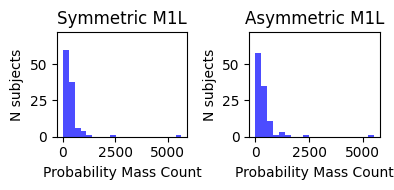

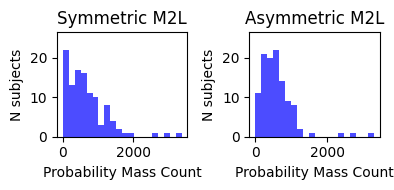

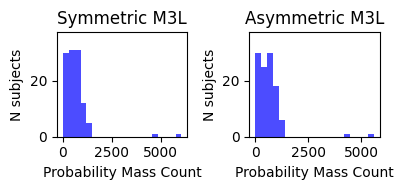

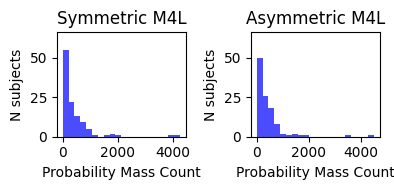

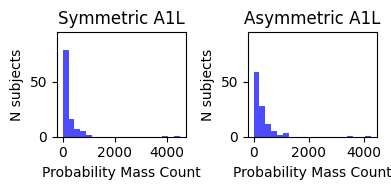

In [19]:
plot_counts(sym_sumP, asym_sumP)